## **변화와 관계 단원** 서술형 답안 자동 분류 및 채점(Team5)

### 문항 설명

* 문항 1. 일차방정식 - 일차방정식의 활용      
    - 성취기준
    [9수02-04] 일차방정식을 풀 수 있고, 이를 활용하여 문제를 해결할 수 있다.
* 문항 2. 좌표평면과 그래프 - 그래프의 해석
    - 성취기준
    [9수03-01] 순서쌍과 좌표를 이해하고, 그 편리함을 인식할 수 있다.     
    [9수03-02] 다양한 상황을 그래프로 나타내고, 주어진 그래프를 해석할 수 있다. 


### 데이터 처리 과정
* 문항별 응답(약 180명의 응답)을 먼저 손으로 라벨링(채점)
* 분포 확인(시각화)
* 텍스트 문항을 data, 라벨링(채점) 결과를 ydata로 지정
* 서술형 답안 tokenizing
    * transformers : `T5tokenizer()` 함수를 이용해 래핑해서 사용할 수 있음 (T5 model의 Text-to-Text 처리를 위해 pretrained 된 sentencepiece tokenizer를 사용하기 위한 함수)
    * T5 : Text-To-Text Transfer Transformer (by Google, 2020)
    * [허깅페이스 링크]('https://huggingface.co/transformers/v4.1.1/model_doc/t5.html')
    * Wordpiece(huggingface)

In [ ]:
# google colab 버전 ###########
# 나눔 폰트 설치
################ 설치 먼저 하고, [런타임]>[런타임 다시 실행]한 후 아래 셀부터 돌려야 함. 
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# 필요한 패키지 설치
!pip install transformers --quiet
!pip install sentencepiece --quiet # --quiet 붙이면 조용히 설치
from google.colab import drive
drive.mount("/content/gdrive/")
path = "/content/gdrive/MyDrive/"

In [11]:
# 로컬 버전
path = './'

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

plt.rc('font', family='NanumBarunGothic') 
plt.rc('font', family='Malgun Gothic') 

# 자카드 유사도 계산 함수 정의
def jaccard_similarity(vector1, vector2):
    intersection = np.logical_and(vector1, vector2).sum()
    union = np.logical_or(vector1, vector2).sum()
    return intersection / union # similarity

# 코사인 유사도 계산 함수 정의
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)

# 탐색적 데이터 분석
def EDA(df, n_element):
    s = 5
    temp = df.iloc[:, 2:2+n_element]

    # barplot ###############
    plt.figure(figsize = (s, s))
    plt.title('인지요소별 정답률')
    heights = (temp.sum() / len(temp)).tolist()
    plt.bar(temp.columns, heights)
    for i, height in enumerate(heights):
        plt.text(i, height, str(round(height, 2)), ha='center', va='bottom')
    plt.xlabel('인지요소')
    plt.xticks(rotation=90)
    plt.show()

    # scatter plot ###############
    corr, _ = pearsonr(df['글자수'], df['총점'])
    plt.figure(figsize = (s, s))
    plt.title('글자수와 응답 총점의 관계/'+f'상관계수: {corr:.2f}')
    plt.scatter(df['글자수'], df['총점'])
    # 선형 회귀 모델 학습
    x = df['글자수'].values.reshape(-1, 1)
    y = df['총점'].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    plt.plot(x, y_pred, color='red', linewidth=2)
    plt.xlabel('글자수')
    plt.ylabel('총점')
    plt.show()

    # 학생 응답 패턴 ###############
    temp_sorted = temp.sort_values(temp.columns.tolist(), axis=0, ascending=True)
    temp_sorted = temp_sorted[temp_sorted.T.sum()!=0]
    plt.figure(figsize = (s, s))
    plt.title('학생 응답 형태(all 0 제외 : {}명)'.format(len(temp_sorted)))
    sns.heatmap(temp_sorted, annot=False, vmin=0, vmax=1, cmap='Blues')
    plt.show()

    # 유사도 heatmap ###############
    plt.figure(figsize = (s, s))
    jaccard_matrix = np.zeros((len(temp.columns), len(temp.columns)))
    for i, col1 in enumerate(temp.columns):
        for j, col2 in enumerate(temp.columns):
            jaccard_matrix[i, j] = jaccard_similarity(temp[col1], temp[col2])
    cosine_matrix = np.zeros((len(temp.columns), len(temp.columns)))
    for i, col1 in enumerate(temp.columns):
        for j, col2 in enumerate(temp.columns):
            cosine_matrix[i, j] = cosine_similarity(temp[col1], temp[col2])
    plt.title('인지요소의 유사도')
    sns.heatmap(cosine_matrix, annot=True, square=True, vmin=0, vmax=1, cmap='Blues', xticklabels=temp.columns, yticklabels=temp.columns)
    plt.show()

# 유의미 늘리기 함수
def meaningful(df, n_times):# '무의미'가 있는 행을 넣기 (df1 or df2)
    temp = df.copy()
    mean_df = temp[temp['무의미']==0]
    for n in range(n_times):
        temp = pd.concat([temp, mean_df])
    temp = temp.drop('무의미', axis = 1)
    return temp


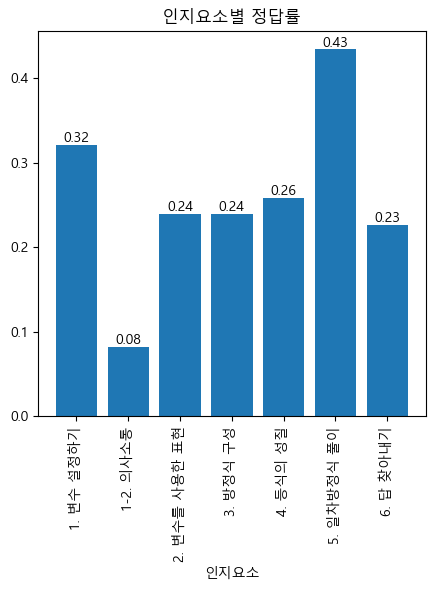

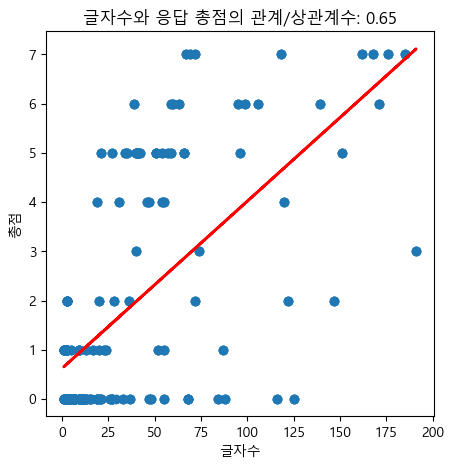

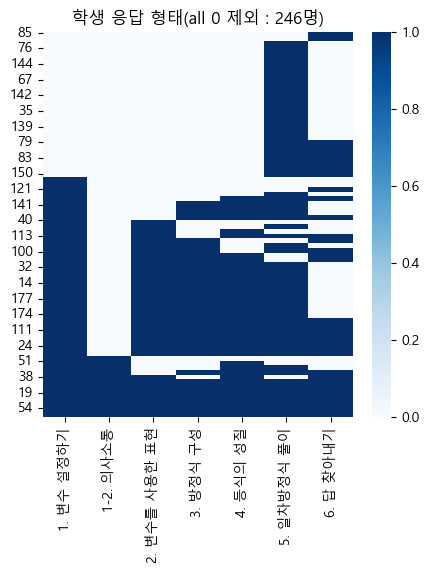

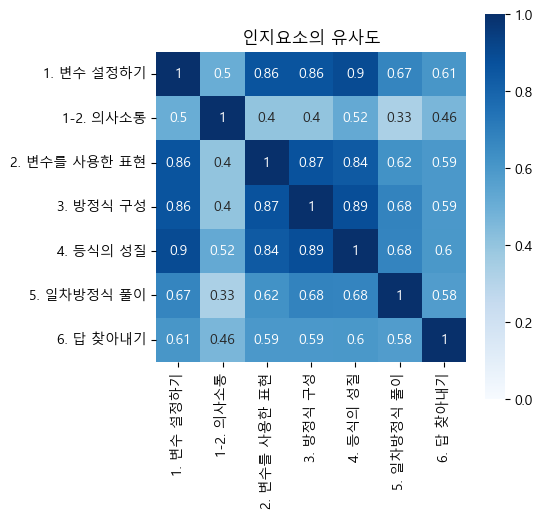

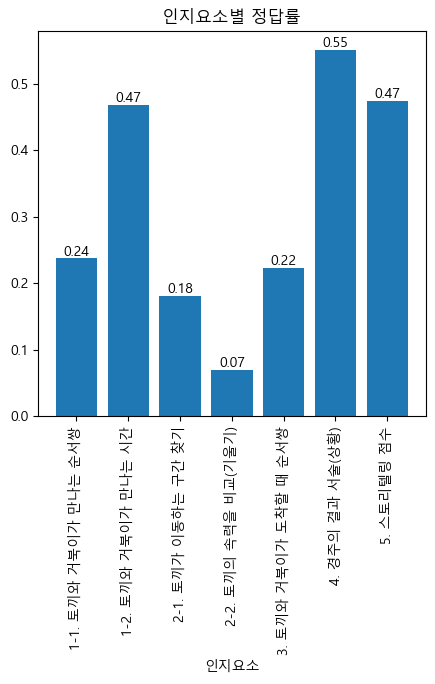

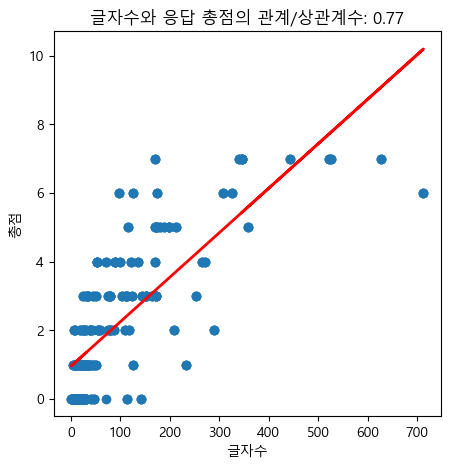

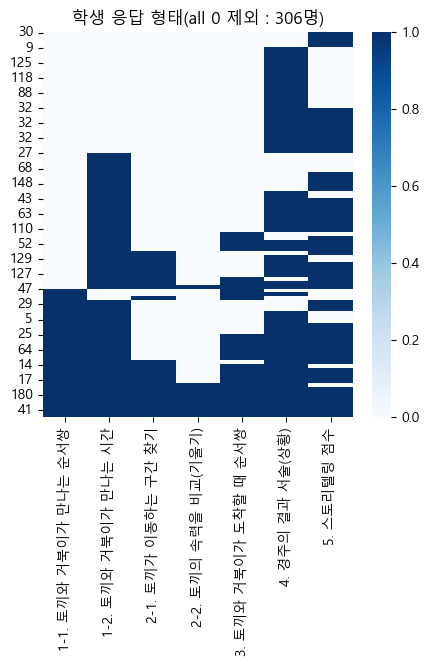

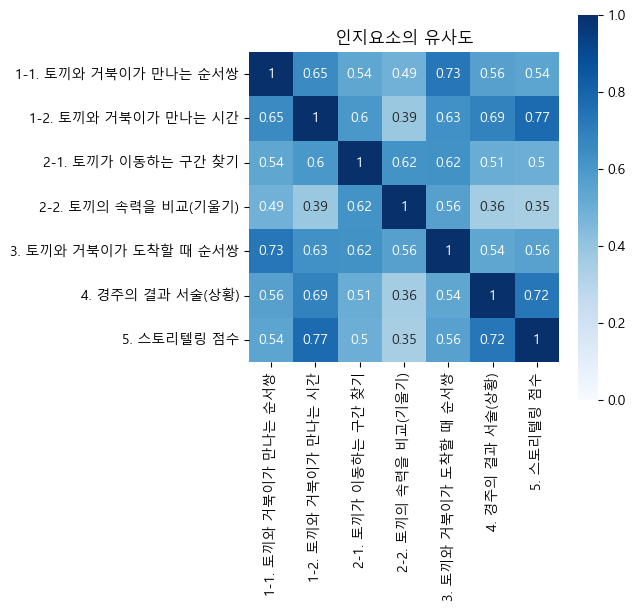

In [42]:
import sentencepiece as spm
from pathlib import Path
import pandas as pd
import numpy as np
import csv

folder_name = 'exercise' # 폴더명 입력
df1 = pd.read_csv(path+folder_name+'/'+'ex1_scoring_meaning.csv').fillna(0) # 문항 1 # 인지요소 6개
df2 = pd.read_csv(path+folder_name+'/'+'ex2_scoring_meaning.csv').fillna(0) # 문항 2 # 인지요소 7개

# 인지요소 열 이름 수정
df1.columns = ['순서', '이메일 주소', '글자수', '답안', 
               '1. 변수 설정하기',
               '2. 변수를 사용한 표현', 
               '3. 방정식 구성',
               '4. 등식의 성질', 
               '5. 일차방정식 풀이', 
               '6. 답 찾아내기',
               '무의미', '점수합계', '특이사항']
df2.columns = ['순서', '이메일 주소', '글자수', '답안',
              '1-1. 토끼와 거북이가 만나는 순서쌍',
              '1-2. 토끼와 거북이가 만나는 시간', 
              '2-1. 토끼가 이동하는 구간 찾기',
              '2-2. 토끼의 속력을 비교(기울기)',
              '3. 토끼와 거북이가 도착할 때 순서쌍',
              '4. 경주의 결과 서술(상황)',
              '5. 스토리텔링 점수',
              '무의미', '6. (오개념)  x, y 혼동', '7. 단위 실수', '특이사항',
              '_']

# 필요없는 열
df1 = df1.drop(['순서', '글자수', '점수합계', '특이사항'], axis = 1)
df2 = df2.drop(['순서', '글자수', '6. (오개념)  x, y 혼동', '7. 단위 실수', '특이사항', '_'], axis = 1)

# df1에 새로운 요소 추가(의사소통)
df1['1-2. 의사소통'] = 0  # 초기값 0으로 설정
df1.loc[df1['1. 변수 설정하기'] == 2, '1-2. 의사소통'] = 1  # 조건을 만족하는 행에 대해 값을 1로 설정
df1 = df1[['이메일 주소', '답안', '1. 변수 설정하기','1-2. 의사소통', '2. 변수를 사용한 표현', 
           '3. 방정식 구성', '4. 등식의 성질', '5. 일차방정식 풀이', '6. 답 찾아내기', '무의미']]
# 채점 # 1점짜리 문항으로 스케일 조정하기
df1.loc[:, '1. 변수 설정하기'] = df1.loc[:, '1. 변수 설정하기'].replace(2, 1)
df2.loc[:, '3. 토끼와 거북이가 도착할 때 순서쌍'] = df2.loc[:, '3. 토끼와 거북이가 도착할 때 순서쌍'].replace(2, 1)
df2.loc[:, '5. 스토리텔링 점수'] = df2.loc[:, '5. 스토리텔링 점수'].replace({3: 1, -1: 0, 0: 0, 1: 1, 2: 1})


df3 = pd.merge(df1, df2, on='이메일 주소', how='inner')
df3['답안'] = df3['답안_x']+df3['답안_y']
df1_elements = df1.columns[2:9].tolist()
df2_elements = df2.columns[2:9].tolist()
df3 = df3[['이메일 주소', '답안']+df1_elements+df2_elements]

# display(df1.head())
# print(df1.shape)
# display(df2.head())
# print(df2.shape)
# display(df3.head())
# print(df3.shape)

df1 = meaningful(df1, 2) # 유의미 두번 추가
df2 = meaningful(df2, 2) # 유의미 두번 추가

df1['글자수'] = df1['답안'].apply(lambda x: len(x))
df1['총점'] = df1[df1_elements].T.sum()
df2['글자수'] = df2['답안'].apply(lambda x: len(x))
df2['총점'] = df2[df2_elements].T.sum()
df3['글자수'] = df3['답안'].apply(lambda x: len(x))
df3['총점'] = df3[df1_elements+df2_elements].T.sum()

EDA(df1, 7)
EDA(df2, 7)

from transformers import T5Tokenizer
from transformers import AutoTokenizer
from tokenizers import BertWordPieceTokenizer

# 답안, 라벨링 분리 함수 : df, df_elements > data, ydata
def slice(df, df_elements):
    ### 답안 텍스트만 불러오기, data
    data = df['답안'].tolist()
    ### label(채점결과) 데이터, ydata
    ydata = df[df_elements].values # 1열(2번째 열)부터 6개 가져오기
    return data, ydata

# 토크나이징 : 문항번호, 단어장 개수 > encoded_data_wp(토큰화된 결과(list), wp(BertWordPieceTokenizer)
def token(index, vocab_size):

    #token(1, 335~890)
    #token(2, 874~2830)
    #token(3, 931~3355)

    #print('문항 {}에 대한 tokenizer, 단어 개수 : {}'.format(index, vocab_size))
    # 데이터와 레이블 선택
    data = eval('data_'+str(index))
    ydata = eval('ydata_'+str(index))
        
    # 데이터 디렉토리와 파일 경로 설정
    data_dir = path + folder_name + '/'
    paths = [str(x) for x in Path(data_dir).glob("ex{}_scoring.txt".format(index))]
    corpus = ",".join(paths)
    
    # BertWordPieceTokenizer를 사용하여 단어를 토큰화하고 정수 인코딩
    wp = BertWordPieceTokenizer(lowercase=False, strip_accents=False)
    data_file = path + folder_name + '/' + 'ex{}_scoring.txt'.format(index)
    # print(data_file)
    limit_alphabet = 6000
    min_frequency = 1

    wp.train(
        files=data_file,
        vocab_size=vocab_size,
        limit_alphabet=limit_alphabet,
        min_frequency=min_frequency
    )

    # 학습된 단어장 저장
    wp.save_model(path + folder_name + '/', 'ex{}_wp'.format(index))
    # print(wp)
    # 학습된 단어장 불러오기
    vocab = wp.get_vocab()

    # 단어장을 데이터프레임으로 변환
    vocab_df = pd.DataFrame(list(vocab.items()), columns=['단어', '인덱스'])
    #display(vocab_df.T)

    encoded_data_wp = []
    for s in data:
        encoded = wp.encode(s)
        encoded_data_wp.append(encoded.ids)

    # 인코딩 잘 되었나 비교
    print('단어장 단어 개수 :', max(max(row) for row in encoded_data_wp))
    #display(pd.DataFrame({"문장":data, "인코딩 후":encoded_data_wp}).head(10))

    # 예시(문장)
    if index ==1 :
        sample_text = '가로의 길이를 x라고 할 때 8*x=120'
    elif index ==2:
        sample_text = "토끼는 중간에 낮잠을 자서  거북이가 이겼다. "
    sample_index = wp.encode(sample_text).ids
    print(sample_text, sample_index)
    # display(vocab_df[vocab_df['인덱스'].isin(sample_index)].T)
    return encoded_data_wp, wp

data_1, ydata_1 = slice(df1, df1_elements)
data_2, ydata_2 = slice(df2, df2_elements)
data_3, ydata_3 = slice(df3, df1_elements+df2_elements)

- 나중에 transformers 패키지의 T5tokenizer에서 래핑해서 쓸때 필요한 `<pad>`, `<sep>`, `<cls>`,`<mask>` 스페셜 토큰을 추가해서 tokenizing 함

단어장 단어 개수 : 499
가로의 길이를 x라고 할 때 8*x=120 [350, 361, 462, 195, 99, 22, 8, 36, 25, 338]


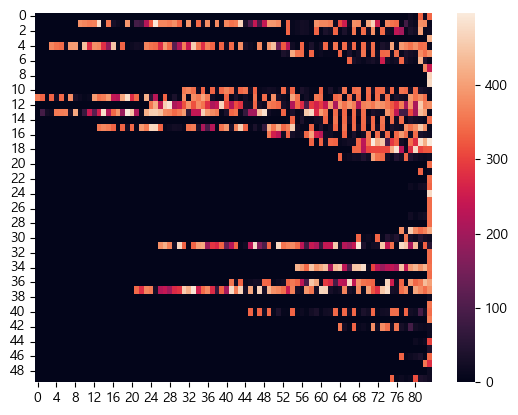

단어장 단어 개수 : 1999
토끼는 중간에 낮잠을 자서  거북이가 이겼다.  [878, 1041, 133, 646, 534, 1829, 880, 906, 11]


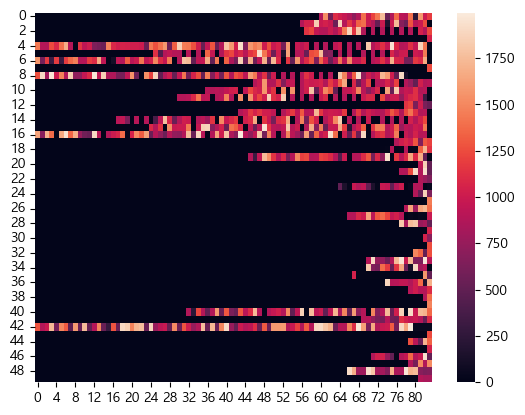

In [45]:
encoded_data_wp, wp = token(1, 500)
encoded_data_wp
X = pad_sequences(encoded_data_wp, maxlen=max_len, padding='pre')
sns.heatmap(X[50:100])
plt.show()

encoded_data_wp, wp = token(2, 2000)
encoded_data_wp
X = pad_sequences(encoded_data_wp, maxlen=max_len, padding='pre')
sns.heatmap(X[50:100])
plt.show()

### 인지요소 분류 과정(RNN, LSTM)
* [메일 분류 예제 링크]('https://wikidocs.net/22894')
* 패딩
    - RNN을 위한 input sequence의 길이가 다 다르므로 padding을 적용한다. 
    - keras의 pad_sequence 함수 사용
* RNN 이용한 학습과 결과 확인
    * 학습된 RNN을 이용하여 훈련 데이터 전체의 예측 결과 확인

### 실험 함수 제작 및 사용
* train_and_predict(index, vocab_size, indices, model_type, embedding_dim, n_epoch, hidden_units, activation)
    * train, testset 분리
    * metric, ROC curve 등 출력

* train_and_predict_compare(index_list, vocab_size_list, indices_list, model_type_list, embedding_dim_list, n_epoch_list, hidden_units_list, activation_list)
    * 위의 함수를 여러 번 사용한 결과를 보기 쉽게 정리(표로 출력)

* train_test_split_and_predict(index, vocab_size, indices, model_type, embedding_dim, n_epoch, hidden_units, activation)
    * train, testset 분리함(7:3 ,randomstate = 42)
    * metric, ROC curve 등 출력

* train_test_split_and_predict_compare(index_list, vocab_size_list, indices_list, model_type_list, embedding_dim_list, n_epoch_list, hidden_units_list, activation_list)
    * 위의 함수를 여러 번 사용한 결과를 보기 쉽게 정리(표로 출력)
    

- 정확도가 올라가는 이유?
- 0점인 경우가 많을 때. 
- 분석할 답안이 복잡할 때 정확도에 영향을 끼칠 것이다. 
- 유의미한 답안/ 무의미한 답안 수작업 분류 > 유의미한것만 불러오기(50개정도 줄어듬)
- 문항 1, 2의 학습요소 사이의 관계를 보면 좋을듯

#### 실험함수 2 : train,test 분리(7:3)

# 문항 1 # 단어 개수 500, 인지요소 인덱스 [0, 1, 2, 3, 4, 5, 6], 적용 모델 : SimpleRNN....
단어장 단어 개수 : 499
가로의 길이를 x라고 할 때 8*x=120 [350, 361, 462, 195, 99, 22, 8, 36, 25, 338]
5/5 [==============================] - 1s 9ms/step


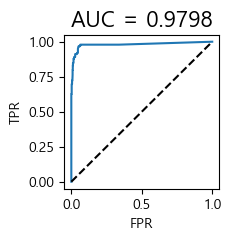

1008 1008


문항번호                                      1
Vocab Size                              500
Indices               [0, 1, 2, 3, 4, 5, 6]
Model Type                        SimpleRNN
embedding_dim                            10
n_epoch                                  30
Hidden Units                             32
Activation                             relu
Accuracy(모든 인지요소)                  0.708333
Confusion matrix     [[742, 28], [21, 217]]
Accuracy                           0.951389
F1 Score                           0.898551
Precision                          0.885714
Recall                             0.911765
AUC                                0.979843
dtype: object

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, LSTM, Attention, GlobalAveragePooling1D, Dense
from keras.layers import Input
from keras.models import Model


# 테스트셋 분리해서 예측 : parameter >  metrics(메트릭), wp(토크나이저), model
def train_test_split_and_predict(index, vocab_size, indices, model_type,
                                  embedding_dim, n_epoch, hidden_units, activation):
    print("# 문항 {} # 단어 개수 {}, 인지요소 인덱스 {}, 적용 모델 : {}....".format(index, vocab_size, indices, str(model_type).split('.')[-1].split("'")[0]))

    # 지정된 문항 인덱스에 따라 데이터 설정하기
    data = eval('data_'+str(index))
    ydata = eval('ydata_'+str(index))

    # 인코딩 결과 가져오기
    encoded_data_wp, wp = token(index, vocab_size) # len : 학생 응답 수 만큼

    # 모델 생성
    # 가장 긴 문장 기준으로 max_len설정
    max_len = max(len(l) for l in encoded_data_wp)
    # 답안별로 문장 길이가 다르므로 빈 부분에 0을 넣어서 모두 길이를 84로 통일시킴
    X = pad_sequences(encoded_data_wp, maxlen=max_len, padding='pre')
    y = ydata.T[indices].T

    # 훈련 세트와 테스트 세트로 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # print('훈련용 데이터 수 :', len(X_train), '테스트용 데이터 수 :', len(X_test))
    # print(X_train[0], X_test[0])
    # # print('테스트용 데이터 분포')
    # token_distribution(X_train, X_test)
    output_units = len(y[0])

    model = Sequential()# 층(layer)을 순차적으로 쌓아 구성됩니다.
    model.add(Embedding(vocab_size, embedding_dim))# Embedding 층 추가
    model.add(model_type(hidden_units))
    model.add(Dense(output_units, activation=activation))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
    history = model.fit(X_train, y_train, epochs=n_epoch, verbose = 0)

    ############추가(Attention..모르겠음 ㅠㅠ)
    # input_layer = Input(shape=(max_len, ), dtype='int32')
    # embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_layer)
    # lstm_layer = LSTM(hidden_units, return_sequences=True)(embedding_layer)
    # attention_layer = Attention(use_scale=True)([lstm_layer, lstm_layer])
    # pooling_layer = GlobalAveragePooling1D()(attention_layer)
    # output_layer = Dense(1, activation = 'relu')(pooling_layer)
    # model2 = Model(inputs = input_layer, outputs = output_layer)
    # model2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

    # 예측
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
   
    # 각 행의 원소들이 일치하는지 여부를 나타내는 불리언 배열 생성해서 정확도 계산
    accuracy_indices = np.mean(np.all(y_test == y_pred_classes, axis=1))

    # AUC 계산
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    auc = roc_auc_score(y_test_flat, y_pred_flat)
    fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_flat)

    # ROC 커브 그리기
    plt.figure(figsize=(2, 2))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('AUC = %0.4f' % auc, fontsize=16)
    plt.show()

    # 혼동 행렬 관련 metric계산
    y_pred_classes = y_pred_classes.flatten()
    print(len(y_test_flat), len(y_pred_classes))
    confusion_mat = confusion_matrix(y_test_flat, y_pred_classes)
    accuracy = accuracy_score(y_test_flat, y_pred_classes)
    f1 = f1_score(y_test_flat, y_pred_classes)
    precision = precision_score(y_test_flat, y_pred_classes)
    recall = recall_score(y_test_flat, y_pred_classes)

    metrics = pd.Series({
        "문항번호": index,
        "Vocab Size": vocab_size,
        "Indices": indices,
        "Model Type": str(model_type).split('.')[-1].split("'")[0],  # 클래스명에서 "SimpleRNN" 추출
        "embedding_dim":embedding_dim, 
        "n_epoch":n_epoch, 
        "Hidden Units": hidden_units,
        "Activation": activation,
        "Accuracy(모든 인지요소)": accuracy_indices,
        "Confusion matrix": confusion_mat,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc
    })

    return metrics, wp, model
    
# train에서 test셋이 골고루 추출되었는지 확인
def token_distribution(X_train, X_test):
    counts_test = []
    for i in range(len(X_test)):
        count = sum(1 for element in X_test[i] if element != 0)
        counts_test.append(count)

    counts_train = []
    for i in range(len(X_train)):
        count = sum(1 for element in X_train[i] if element != 0)
        counts_train.append(count)

    max_size = max(max(counts_test), max(counts_train))
    plt.figure(figsize = (3,3))
    sns.histplot(counts_train, label = 'train_'+str(len(X_train)), binwidth = 5, binrange = [0, max_size] )  # 히스토그램 생성
    sns.histplot(counts_test,  label = 'test_'+str(len(X_test)), binwidth = 5, binrange = [0, max_size])  # 히스토그램 생성
    plt.xlabel('Count')  # x축 레이블
    plt.ylabel('Frequency')  # y축 레이블
    plt.title('토큰 수 Distribution')  # 그래프 제목
    plt.legend()  # 범례 생성
    plt.show()

# 비교용 : metric 비교 dataframe(여러 개의 알고리즘을 표로 비교)
def train_test_split_and_predict_compare(index_list, vocab_size_list, indices_list, model_type_list, 
                                         embedding_dim_list, n_epoch_list, hidden_units_list, activation_list):
    metrics_list = []
    for index, vocab_size, indices, model_type, embedding_dim, n_epoch, hidden_units, activation in itertools.product(index_list, vocab_size_list, indices_list, model_type_list, embedding_dim_list, n_epoch_list, hidden_units_list, activation_list):
        metrics, wp, model = train_test_split_and_predict(index, vocab_size, indices, model_type, embedding_dim, n_epoch, hidden_units, activation)
        metrics_list.append(metrics)
    return pd.DataFrame(metrics_list)

# 새로운 텍스트 시험용 : wp, model, text list > prediction(분류 결과)
def test_new_texts(index, wp, model, texts):
    predictions = [model.predict([wp.encode(text).ids]).flatten().tolist() for text in texts]
    if index == 1:
        class_labels = ['A1-1', 'A1-1-2', 'A1-2', 'A1-3', 'A1-4', 'A1-5', 'A1-6']
    elif index == 2:
        class_labels = ['A2-1-1', 'A2-1-2', 'A2-2-1', 'A2-2-2', 'A2-3', 'A2-4', 'A2-5']
    #["Class {}".format(i+1) for i in range(len(predictions[0]))]
    predictions = pd.DataFrame(predictions, index=texts, columns=class_labels)
    display(np.round(predictions,2))
    #return predictions

# # # 예시
# metrics, wp, model = train_test_split_and_predict(2, 1000, [0], SimpleRNN, 10, 30, 32, 'relu')
# train_test_split_and_predict_compare([1,2], [1000], [[0,1,2]], [SimpleRNN], [10], [30], [32], ['relu'])
metrics, wp, model = train_test_split_and_predict(1, 500, [0,1,2,3,4,5,6], SimpleRNN, 10, 30, 32, 'relu')
metrics

# 문항 2 # 단어 개수 2000, 인지요소 인덱스 [0, 1, 2, 3, 4, 5, 6], 적용 모델 : SimpleRNN....
단어장 단어 개수 : 1999
토끼는 중간에 낮잠을 자서  거북이가 이겼다.  [878, 1041, 133, 854, 538, 1829, 880, 906, 11]


,5,88,219,614,637,768,937,1019,1324
단어,중간에,거북이가,이겼다,낮,자서,##잠,##을,.,토끼는
인덱스,1041,880,906,133,1829,854,538,11,878


5/5 [==============================] - 0s 23ms/step


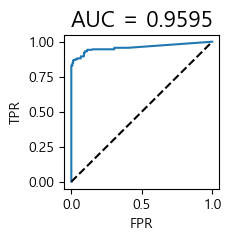

903 903
# 문항 2 # 단어 개수 2000, 인지요소 인덱스 [0, 1, 2, 3, 4, 5, 6], 적용 모델 : LSTM....
단어장 단어 개수 : 1999
토끼는 중간에 낮잠을 자서  거북이가 이겼다.  [878, 1041, 133, 649, 531, 1829, 880, 906, 11]


,53,505,751,936,1411,1414,1493,1749,1989
단어,.,##을,낮,이겼다,토끼는,거북이가,중간에,##잠,자서
인덱스,11,531,133,906,878,880,1041,649,1829


5/5 [==============================] - 1s 48ms/step


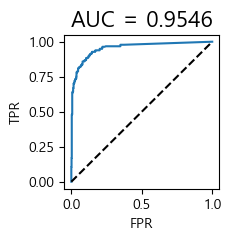

903 903
# 문항 2 # 단어 개수 2000, 인지요소 인덱스 [0, 1, 2, 3, 4, 5, 6], 적용 모델 : GRU....
단어장 단어 개수 : 1999
토끼는 중간에 낮잠을 자서  거북이가 이겼다.  [878, 1041, 133, 750, 520, 1829, 880, 906, 11]


,41,248,360,1211,1281,1605,1746,1799,1914
단어,##을,자서,낮,.,중간에,거북이가,토끼는,이겼다,##잠
인덱스,520,1829,133,11,1041,880,878,906,750


5/5 [==============================] - 1s 37ms/step


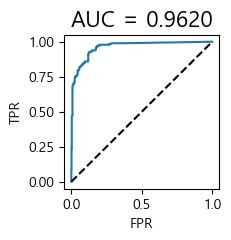

903 903


,문항번호,Vocab Size,Indices,Model Type,embedding_dim,n_epoch,Hidden Units,Activation,Accuracy(모든 인지요소),Confusion matrix,Accuracy,F1 Score,Precision,Recall,AUC
0,2,2000,"[0, 1, 2, 3, 4, 5, 6]",SimpleRNN,10,30,32,relu,0.790698,"[[592, 34], [33, 244]]",0.925803,0.879279,0.877698,0.880866,0.959470
1,2,2000,"[0, 1, 2, 3, 4, 5, 6]",LSTM,10,30,32,relu,0.589147,"[[596, 30], [59, 218]]",0.901440,0.830476,0.879032,0.787004,0.954649
2,2,2000,"[0, 1, 2, 3, 4, 5, 6]",GRU,10,30,32,relu,0.565891,"[[590, 36], [50, 227]]",0.904762,0.840741,0.863118,0.819495,0.961967


In [38]:
metric_df = train_test_split_and_predict_compare([2], [2000], [[0,1,2,3,4,5,6]], [SimpleRNN , LSTM, GRU], [10], [30], [32], ['relu'])
metric_df